In [3]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [4]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624271 sha256=58cb4ed81de5b519a5734f59d0f4836d14379a1212cacfc718b89f2c8939c63c
  Stored in directory: /tmp/pip-ephem-wheel-cache-kjnmtan5/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [9]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [10]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


In [11]:
train_image_dir = 'models/research/object_detection/test_images/ducky/train/'
train_images_np = []
for i in range(1, 6):
  image_path = os.path.join(train_image_dir, 'robertducky' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

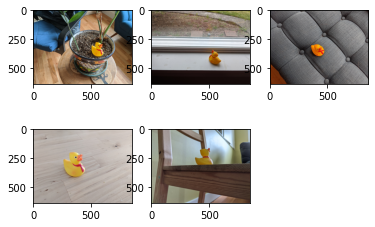

In [12]:
for idx,images in enumerate(train_images_np):
  plt.subplot(2,3,idx+1)
  plt.imshow(images)

In [15]:
##using with hand 
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)
#gt_boxes = [
             #np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),
             #np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
            #np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
             #np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
             #np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
#]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [16]:
gt_boxes

[array([[0.422     , 0.56623681, 0.64033333, 0.73505275]]),
 array([[0.53033333, 0.54865182, 0.762     , 0.73036342]]),
 array([[0.44866666, 0.34935522, 0.657     , 0.58382181]]),
 array([[0.28866666, 0.27315358, 0.67033333, 0.53810082]]),
 array([[0.24366666, 0.42555686, 0.487     , 0.63657679]])]

In [ ]:
duck_class_id = 1
num_classes = 1
category_index={duck_class_id:{'id':duck_class_id,'name':'rubbery_duck'}}
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

In [ ]:
for (train_image,gt_box) in zip(train_images_np,gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image,dtype=tf.float32),axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box,dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

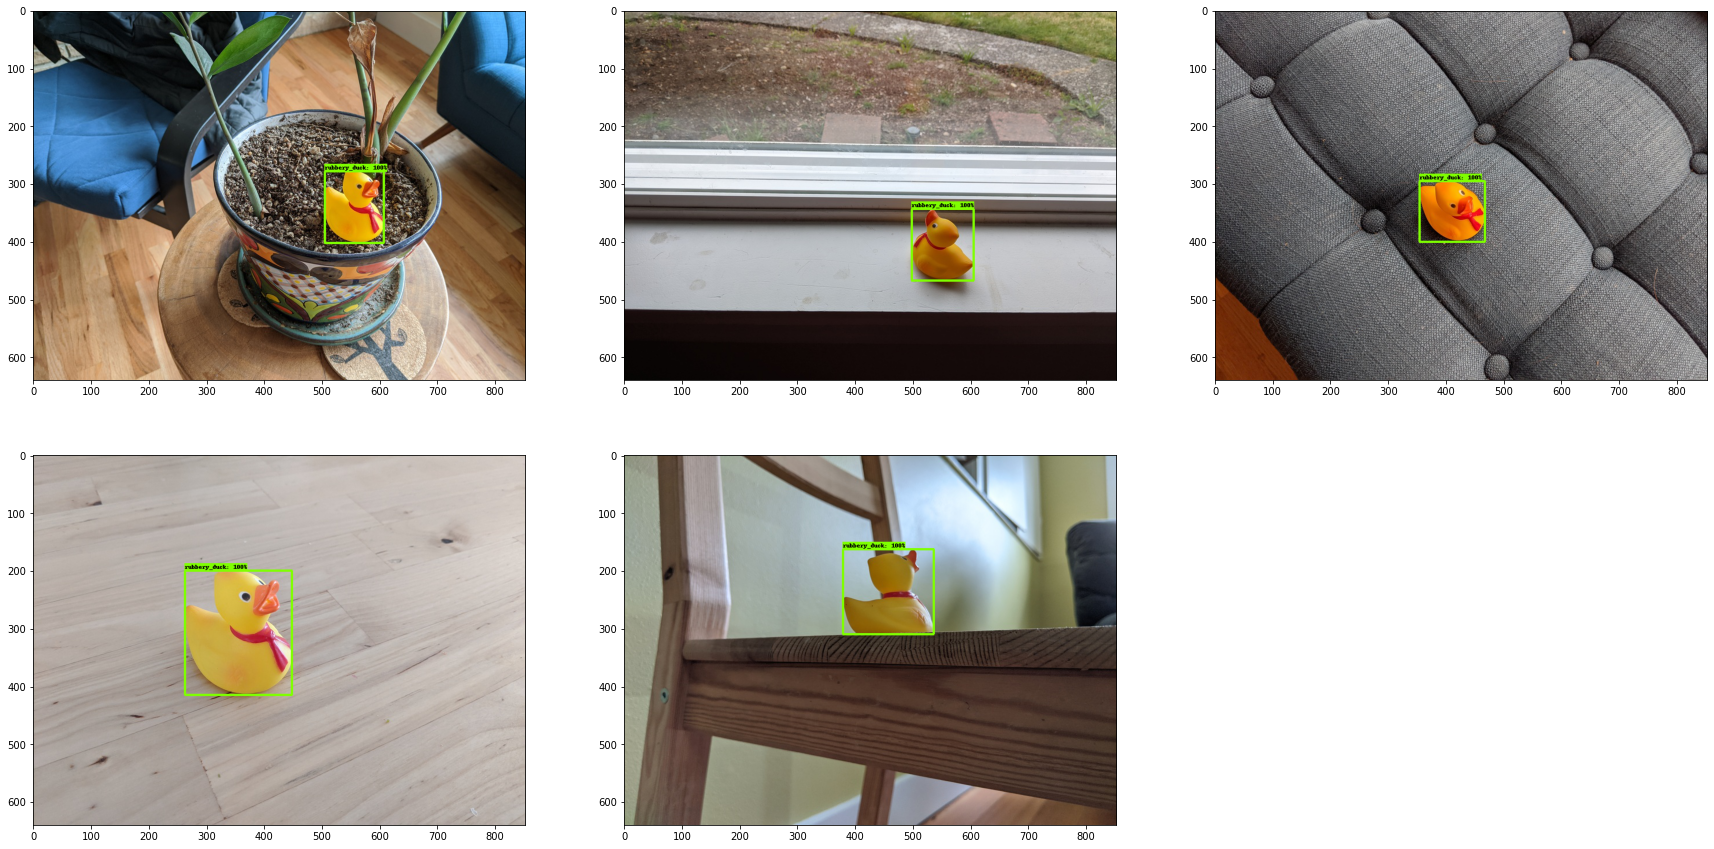

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(train_images_np[idx],gt_boxes[idx],
                  np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
                  scores=dummy_scores,
                  category_index=category_index)

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-01-11 15:41:46--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.13.80, 2607:f8b0:4004:808::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.13.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   103MB/s    in 2.3s    

2021-01-11 15:41:48 (103 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

In [ ]:
config=config_util.get_configs_from_pipeline_file(pipeline_config)
model_config=config['model']
model_config.ssd.num_classes=num_classes
model_config.ssd.freeze_batchnorm=True
detection_model=model_builder.build(model_config,is_training=True)

In [ ]:
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

In [ ]:
image,shapes=detection_model.preprocess(tf.zeros([1,640,480,3]))
pred_dict=detection_model.predict(image,shapes)
_=detection_model.postprocess(pred_dict,shapes)

In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

def get_model_step_function(model,optimizer,vars_to_fine_tune):
  @tf.function
  def train_step(image_tensors,
                 ground_truth_box,
                 ground_truth_class):
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(groundtruth_boxes_list=ground_truth_box,
        groundtruth_classes_list=ground_truth_class)
    with tf.GradientTape() as tape:
      preprocessed_image=tf.concat([detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors],axis=0)
      pred_loss=model.predict(preprocessed_image,shapes)
      loss_dict=model.loss(pred_loss,shapes)
      total_loss = loss_dict['Loss/localization_loss'] + loss_dict['Loss/classification_loss']
      gradient=tape.gradient(total_loss,vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradient,vars_to_fine_tune))
    return total_loss
  return train_step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_stp_function=get_model_step_function(detection_model,optimizer,to_fine_tune)


In [ ]:
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_stp_function(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=1.1291885
batch 10 of 100, loss=1.1297407
batch 20 of 100, loss=0.17542964
batch 30 of 100, loss=0.018079752
batch 40 of 100, loss=0.006363922
batch 50 of 100, loss=0.0045989826
batch 60 of 100, loss=0.002240659
batch 70 of 100, loss=0.0021671196
batch 80 of 100, loss=0.0017868568
batch 90 of 100, loss=0.001483138
Done fine-tuning!


In [ ]:
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.



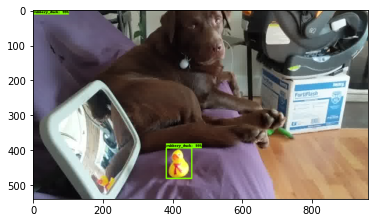

In [ ]:
label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20))

In [ ]:
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  image_np_with_annotations = test_images_np[i].copy()
  plt.figure(figsize=(4,6))
  fig=viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations[0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  
  plt.imshow(fig)

Output hidden; open in https://colab.research.google.com to view.